We are dealing with Network Intrusion Detection System (IDS) on DDOS using autoencoder and Light Gradient Boosting Machine KDD99 dataset

In [1]:
import pandas as pd
import os, io, requests
import numpy as np
from sklearn import metrics
from sklearn.metrics import *
import seaborn as sns
import datetime as dt
from sklearn import preprocessing
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import get_file
# We download 10% of the KDD99 dataset sicne it is over a few million records
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise
    
print(path) 

# This file is a CSV, just no CSV extension or headers
# Download from: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df = pd.read_csv(path, names=[
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome']
)
df

Init Plugin
Init Graph Optimizer
Init Kernel
/Users/tomxu/.keras/datasets/kddcup.data_10_percent.gz


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [2]:
print("Read {} rows.".format(len(df)))
print('='*40)
print('The number of data points are:', df.shape[0])
print('='*40)
print('The number of features are:', df.shape[1])
print('='*40)
output = df['outcome'].values
labels = set(output)
print('The different type of output labels are:', labels)
print('='*125)
print('The number of different output labels are:', len(labels))

Read 494021 rows.
The number of data points are: 494021
The number of features are: 42
The different type of output labels are: {'warezclient.', 'spy.', 'perl.', 'smurf.', 'buffer_overflow.', 'satan.', 'loadmodule.', 'portsweep.', 'pod.', 'ftp_write.', 'ipsweep.', 'nmap.', 'teardrop.', 'back.', 'rootkit.', 'guess_passwd.', 'neptune.', 'normal.', 'imap.', 'warezmaster.', 'multihop.', 'phf.', 'land.'}
The number of different output labels are: 23


In [3]:
# let us compare the output categories with the supplied one
with open("./training_attack_types",'r') as attacks:
    print(attacks.read())

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2l




The KDD 99 dataset includes non-numerical features and duplicates, so this dataset is preprocessed before being inputted into models.
Firstly, the data are deduplicated and disambiguated. Because these duplicate data cause that the model assign a bigger weight to the more frequent data. We need to ensure that there is only one result for a piece of data, these data are disambiguated. After this work, the training dataset consists of 145585 samples and test dataset consists of 77291 samples.
Then, data transformation is applied to the experiment. The symbolic features (protocol_type, services and flag) are mapped to numeric feature by One-Hot Encoding (Buckman et al., 2018). For example, the feature ‘protocol_type’ contains three values: tcp, udp and icmp. These values are mapped to (1, 0, 0), (0, 1, 0) and (0, 0, 1) in turn. However, the label is mapped to numeric feature by Label- Encoding (Zhang et al., 2018). As we have seen in Table 1, the ‘label’ field contains five values, which are mapped to 0, 1, 2, 3 and 4 from top to bottom.
Since Auto-Encoder is used in the framework, it is necessary to standardize the data to eliminate differences caused by the different value scales between features. In this experiment, z-score method is adopted. The standard score of a raw score is calculated as 𝑧=(𝑥 − 𝜇)/𝜎 where 𝜇 is the mean of population and 𝜎 is the standard deviation of the population. We also call this standardization.

In [4]:
# Data Cleaning
# Checking for NULL values
print('Null values in dataset are',len(df[df.isnull().any(1)]))
print('='*40)
print("Read {} rows.".format(len(df)))
# Checkng for DUPLICATE values
df.drop_duplicates(keep='first', inplace = True)
# For now, just drop NA's (rows with missing values)
df.dropna(inplace=True,axis=1) 
# stored the data into a pickle file so we can load through
# df.to_pickle('df.pkl')
print("Read {} rows.".format(len(df)))

Null values in dataset are 0
Read 494021 rows.
Read 145586 rows.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145586 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     145586 non-null  int64  
 1   protocol_type                145586 non-null  object 
 2   service                      145586 non-null  object 
 3   flag                         145586 non-null  object 
 4   src_bytes                    145586 non-null  int64  
 5   dst_bytes                    145586 non-null  int64  
 6   land                         145586 non-null  int64  
 7   wrong_fragment               145586 non-null  int64  
 8   urgent                       145586 non-null  int64  
 9   hot                          145586 non-null  int64  
 10  num_failed_logins            145586 non-null  int64  
 11  logged_in                    145586 non-null  int64  
 12  num_compromised              145586 non-null  int64  
 13 

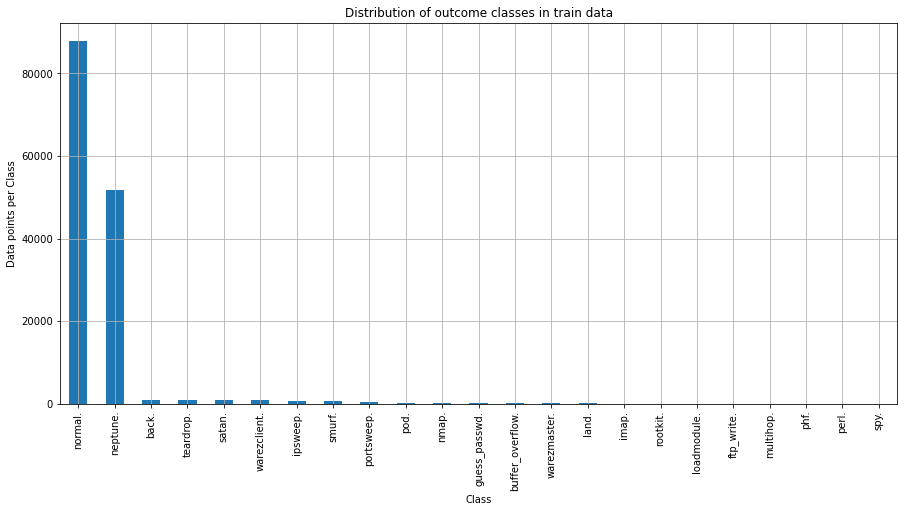

In [6]:
# EDA
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

plt.figure(figsize=(15,7))
class_distribution = df['outcome'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of outcome classes in train data')
plt.grid()
plt.show()

In [7]:
sorted_yi = np.argsort(-class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')
    
#df.groupby('outcome')['outcome'].count() #this could also be used if you want no-fromatted for above.

Number of data points in class normal. : 87832 ( 60.33 %)
Number of data points in class neptune. : 51820 ( 35.594 %)
Number of data points in class back. : 968 ( 0.665 %)
Number of data points in class teardrop. : 918 ( 0.631 %)
Number of data points in class satan. : 906 ( 0.622 %)
Number of data points in class warezclient. : 893 ( 0.613 %)
Number of data points in class ipsweep. : 651 ( 0.447 %)
Number of data points in class smurf. : 641 ( 0.44 %)
Number of data points in class portsweep. : 416 ( 0.286 %)
Number of data points in class pod. : 206 ( 0.141 %)
Number of data points in class nmap. : 158 ( 0.109 %)
Number of data points in class guess_passwd. : 53 ( 0.036 %)
Number of data points in class buffer_overflow. : 30 ( 0.021 %)
Number of data points in class warezmaster. : 20 ( 0.014 %)
Number of data points in class land. : 19 ( 0.013 %)
Number of data points in class imap. : 12 ( 0.008 %)
Number of data points in class rootkit. : 10 ( 0.007 %)
Number of data points in class

In [8]:
ENCODING = 'utf-8'

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

In [9]:
#Encode the feature vector

# Encode a numeric column as zscores so they are automatically scaled, similar to sklearn.preprocessing.StandardScaler
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean(axis=0)
    if sd is None:
        sd = df[name].std(axis=0)
    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue), similar to ohe
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Now encode the feature vector

encode_numeric_zscore(df, 'duration')
encode_text_dummy(df, 'protocol_type')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'flag')
encode_numeric_zscore(df, 'src_bytes')
encode_numeric_zscore(df, 'dst_bytes')
encode_text_dummy(df, 'land')
encode_numeric_zscore(df, 'wrong_fragment')
encode_numeric_zscore(df, 'urgent')
encode_numeric_zscore(df, 'hot')
encode_numeric_zscore(df, 'num_failed_logins')
encode_text_dummy(df, 'logged_in')
encode_numeric_zscore(df, 'num_compromised')
encode_numeric_zscore(df, 'root_shell')
encode_numeric_zscore(df, 'su_attempted')
encode_numeric_zscore(df, 'num_root')
encode_numeric_zscore(df, 'num_file_creations')
encode_numeric_zscore(df, 'num_shells')
encode_numeric_zscore(df, 'num_access_files')
encode_numeric_zscore(df, 'num_outbound_cmds')
encode_text_dummy(df, 'is_host_login')
encode_text_dummy(df, 'is_guest_login')
encode_numeric_zscore(df, 'count')
encode_numeric_zscore(df, 'srv_count')
encode_numeric_zscore(df, 'serror_rate')
encode_numeric_zscore(df, 'srv_serror_rate')
encode_numeric_zscore(df, 'rerror_rate')
encode_numeric_zscore(df, 'srv_rerror_rate')
encode_numeric_zscore(df, 'same_srv_rate')
encode_numeric_zscore(df, 'diff_srv_rate')
encode_numeric_zscore(df, 'srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_count')
encode_numeric_zscore(df, 'dst_host_srv_count')
encode_numeric_zscore(df, 'dst_host_same_srv_rate')
encode_numeric_zscore(df, 'dst_host_diff_srv_rate')
encode_numeric_zscore(df, 'dst_host_same_src_port_rate')
encode_numeric_zscore(df, 'dst_host_srv_diff_host_rate')
encode_numeric_zscore(df, 'dst_host_serror_rate')
encode_numeric_zscore(df, 'dst_host_srv_serror_rate')
encode_numeric_zscore(df, 'dst_host_rerror_rate')
encode_numeric_zscore(df, 'dst_host_srv_rerror_rate')

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]
# This is the numeric feature vector, as it goes to the neural net

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.10785,-0.004293,0.042595,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
1,-0.10785,-0.004261,-0.039036,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
2,-0.10785,-0.004263,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
3,-0.10785,-0.004272,-0.025042,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0
4,-0.10785,-0.004273,-0.013613,-0.084394,-0.004737,-0.070209,-0.018022,-0.007905,-0.01944,-0.008613,...,0,1,0,1,0,0,1,1,1,0


In [10]:
# Convert to numpy - Classification
x_columns = df.columns.drop('outcome')
x = df[x_columns].values # features matrix
dummies = pd.get_dummies(df['outcome']) # encoded label df
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values # encoded label matrix

In [11]:
# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=19)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-22 11:52:27.422290: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-22 11:52:27.422422: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-22 11:52:27.942473: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-22 11:52:27.942885: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-22 11:52:28.089720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/19


2022-05-22 11:52:47.186980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3413/3413 - 23s - loss: 0.2529 - val_loss: 0.1057
Epoch 2/19
3413/3413 - 20s - loss: 0.0977 - val_loss: 0.0877
Epoch 3/19
3413/3413 - 20s - loss: 0.0857 - val_loss: 0.0798
Epoch 4/19
3413/3413 - 20s - loss: 0.0796 - val_loss: 0.0750
Epoch 5/19
3413/3413 - 20s - loss: 0.0743 - val_loss: 0.0708
Epoch 6/19
3413/3413 - 20s - loss: 0.0712 - val_loss: 0.0724
Epoch 7/19
3413/3413 - 20s - loss: 0.0682 - val_loss: 0.0673
Epoch 8/19
3413/3413 - 20s - loss: 0.0655 - val_loss: 0.0666
Epoch 9/19
3413/3413 - 20s - loss: 0.0643 - val_loss: 0.0644
Epoch 10/19
3413/3413 - 20s - loss: 0.0623 - val_loss: 0.0641
Epoch 11/19
3413/3413 - 20s - loss: 0.0608 - val_loss: 0.0634
Epoch 12/19
3413/3413 - 20s - loss: 0.0596 - val_loss: 0.0614
Epoch 13/19
3413/3413 - 20s - loss: 0.0585 - val_loss: 0.0627
Epoch 14/19
3413/3413 - 20s - loss: 0.0577 - val_loss: 0.0596
Epoch 15/19
3413/3413 - 20s - loss: 0.0562 - val_loss: 0.0591
Epoch 16/19
3413/3413 - 20s - loss: 0.0556 - val_loss: 0.0591
Epoch 17/19
3413/3413 - 20s 

In [12]:
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('='*50)
model.summary()

Learning Rate - 
0.001
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                1210      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_4 (Dense)              (None, 23)                46        
Total params: 2,327
Trainable params: 2,327
Non-trainable params: 0
_________________________________________________________________


In [13]:
def confusion_matrix_func(y_test, y_test_pred):    
    '''
    This function computes the confusion matrix using Predicted and Actual values and plots 
    a confusion matrix heatmap
    '''
    C = confusion_matrix(y_test, y_test_pred)
    cm_df = pd.DataFrame(C)
    labels = ['back', 'butter_overflow', 'loadmodule', 'guess_passwd', 'imap', 'ipsweep', 'warezmaster', 'rootkit', 
              'multihop', 'neptune', 'nmap', 'normal', 'phf', 'perl', 'pod', 'portsweep', 'ftp_write', 'satan',
              'smurf', 'teardrop', 'warezclient', 'land']
    plt.figure(figsize=(20,15))
    sns.set(font_scale=1.4)
    sns.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')    
    plt.show()

# calculate roc curve
#fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, pred)

def multiclass_roc_auc_score(y_test, pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    pred = lb.transform(pred)
    return roc_auc_score(y_test, pred, average=average)

print('Train data')
print(x_train.shape)
print(y_train.shape)
print('='*20)
print('Test data')
print(x_test.shape)
print(y_test.shape)
print('='*20)

# Measure accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
print('Predicting on the test data:')
start = dt.datetime.now()
escore = model.evaluate(x_test, y_test, batch_size=32)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)

vscore = metrics.accuracy_score(y_eval, pred)

rscore = recall_score(y_eval, pred, average='weighted')

ascore = precision_score(y_eval, pred, average='weighted')

f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

roc_auc_socre = multiclass_roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)
print('='*50)
print("Validation score: {}".format(vscore))
print('='*50)
print("Evaluation score: {}".format(escore))
print('='*50)
print("Recall score: {}".format(rscore))
print('='*50)
print("Precision score: {}".format(ascore))
print('='*50)
print("F1 score: {}".format(f1score))
print('='*50)
print("ROC-AUC score: {}".format(roc_auc_socre))

Train data
(109189, 120)
(109189, 23)
Test data
(36397, 120)
(36397, 23)
Predicting on the test data:
1138/1138 [==============================] - 5s 4ms/step - loss: 0.0629


2022-05-22 11:59:35.086698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Completed
Time taken: 0:00:06.192773
Validation score: 0.9901365497156359
Evaluation score: 0.06294350326061249
Recall score: 0.9901365497156359
Precision score: 0.9876118253943428
F1 score: 0.9879775884905639
ROC-AUC score: 0.6842537426301163


/Users/tomxu/miniforge3/envs/tf25/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


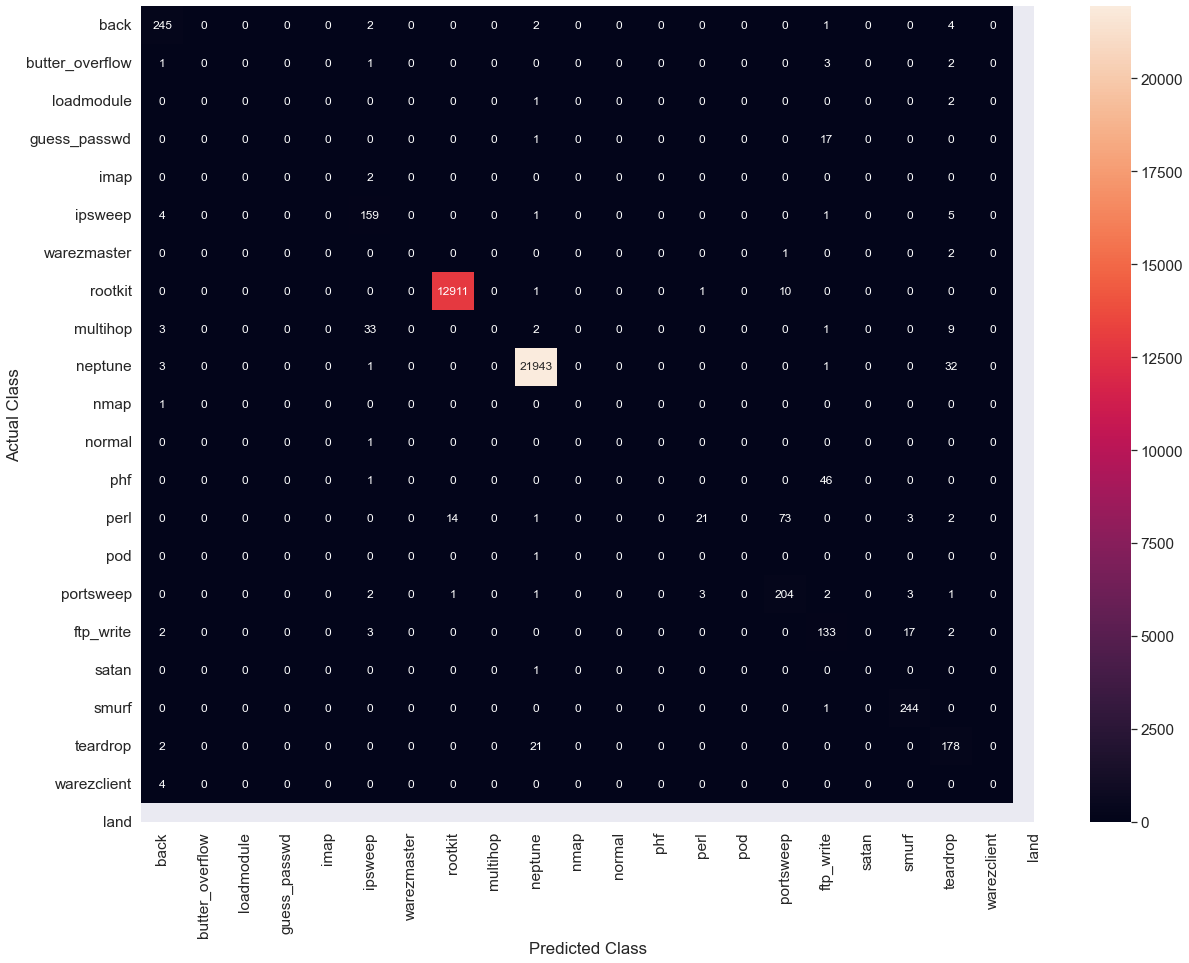

In [14]:
confusion_matrix_func(y_eval, pred)